## Question: Forgetting about power laws, do eqns 17.x actually describe a well-defined distribution?



In [1]:
# bloody dependencies
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as MSE
from scipy.special import zeta, zetac
from scipy.optimize import fsolve

# custom classes
from legomena import Corpus, SPGC

In [2]:
# standard project gutenberg corpus
spgc = SPGC.getMeta()

# for now, restrict study to english-only
spgc = spgc[spgc.language == "['en']"]

# preview
spgc.head()

,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
id,,,,,,,,
1,The Declaration of Independence of the United ...,"Jefferson, Thomas",1743.0,1826.0,['en'],604.0,"{'United States -- History -- Revolution, 1775...",Text
2,The United States Bill of Rights: The Ten Orig...,United States,NaN,NaN,['en'],158.0,"{'Civil rights -- United States -- Sources', '...",Text
3,John F. Kennedy's Inaugural Address,"Kennedy, John F. (John Fitzgerald)",1917.0,1963.0,['en'],28.0,{'Presidents -- United States -- Inaugural add...,Text
4,Lincoln's Gettysburg Address: Given November 1...,"Lincoln, Abraham",1809.0,1865.0,['en'],55.0,{'Consecration of cemeteries -- Pennsylvania -...,Text
5,The United States Constitution,United States,NaN,NaN,['en'],226.0,"{'United States. Constitution', 'United States...",Text


### Choosing a Book

Select a book for use as our fitting corpus.

Number of tokens (<corpus>.M): 210258
Number of types  (<corpus>.N): 16402
Legomena vector  (<corpus>.k): [   0 7197 2781 1555  872  632  439  338  303]
Frequency distribution accessible as <corpus>.fdist
Type-Token Relation data accessible as <corpus>.TTR
Log model accessible as <corpus>.M_z, .N_z
Optimum (M_z,N_z) = (113034, 12245)


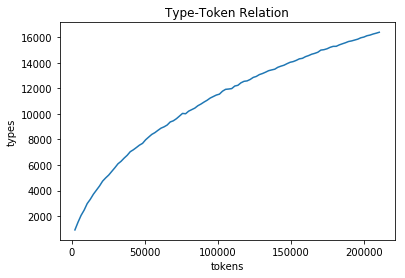

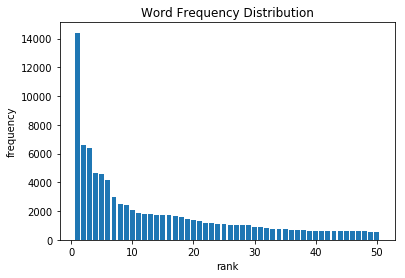

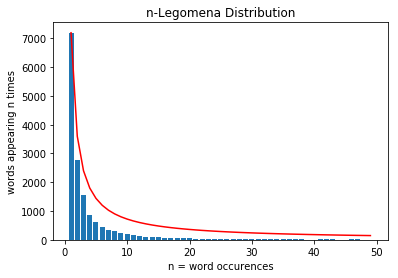

In [68]:
# spgc[spgc.title.str.contains("Bible", na = False)].head()

# moby dick
corpus = SPGC.get(2701)
df = corpus.buildTTRCurve(legomena_upto=7)
M_z, N_z = corpus.fit(optimize = True)
print("Optimum (M_z,N_z) =", (M_z, N_z))

# plot TTR curve
plt.plot(df.m_tokens, df.n_types)
plt.title("Type-Token Relation")
plt.xlabel("tokens")
plt.ylabel("types")
plt.show()

# plot WFD
xmax = 50
df = corpus.fdist.copy().head(xmax)
plt.bar(df["rank"], df["freq"])
plt.title("Word Frequency Distribution")
plt.xlabel("rank")
plt.ylabel("frequency")
plt.show()

# plot the k-vector
i = range(1,50)
plt.bar(i, corpus.k[i])
plt.plot(i, corpus.k[1]/i, color = 'r')
plt.title("n-Legomena Distribution")
plt.xlabel("n = word occurences")
plt.ylabel("words appearing n times")
plt.show()

## The $n$-Legomena Curves

Each $n$-legomena model curve can be derived from the TTR curve, resulting in the following series of equations for ascending values of $n = 0, 1, 2, ...$. They are already "horizontally" normalized such that $x = m/M_z$ and $k_n$ gives the _count_ of the $n$th legomena. By "vertically" normalizing, setting $y(x) = E(x)/N_z, k'_n = k_n/N_z$ we'll obtain legomena _fractions_ rather than counts. Therefore, this series of equations answers the question "what fraction of types $k'_n$ do we expect to observe given $x$ fraction of tokens?"

$$
\begin{equation}
y(x) = \frac{\ln(x)x}{x-1} \tag{17}\label{eq:17}
\end{equation}
$$

$$
\begin{equation}
k'_0(x) = 1 - y(x) = \frac{x-\ln(x)x-1}{x-1} \tag{17.0}\label{eq:17.0}
\end{equation}
$$

$$
\begin{equation}
k'_1(x) = \frac{x^2-\ln(x)x-x}{(x-1)^2} \tag{17.1}\label{eq:17.1}
\end{equation}
$$

$$
\begin{equation}
k'_2(x) = \frac{x^3-2\ln(x)x^2-x}{2(x-1)^3} \tag{17.2}\label{eq:17.2}
\end{equation}
$$

$$
\begin{equation}
k'_3(x) = \frac{2x^4+3x^3-6\ln(x)x^3-6x^2+x}{6(x-1)^4} \tag{17.3}\label{eq:17.3}
\end{equation}
$$

$$
\begin{equation}
k'_4(x) = \frac{3x^5+10x^4-12x^4\ln(x)-18x^3+6x^2-x}{12(x-1)^5} \tag{17.4}\label{eq:17.4}
\end{equation}
$$

$$
\begin{equation}
k'_5(x) = \frac{12x^6+65x^5-60x^5\ln(x)-120x^4+60x^3-20x^2+3x}{60(x-1)^6} \tag{17.5}\label{eq:17.5}
\end{equation}
$$

We've already determined one useful ratio, the hapax ratio, in the original paper: $H(x) = \frac{k_1(x)}{E(x)} = \frac{k'_1(x)}{y(x)} = \frac{1}{\ln(x)}+\frac{1}{1-x}$. Let's exhaust some others...

## General Form

The ratio of $n$-legomena with respect to types as the corpus grows follows this beautiful and mysterious formula:

$$
p_n(x) = \frac{k_n(x)}{E(x)} = \frac{k'_n(x)}{y(x)} = (-1)^{n+1}\frac{x^n}{n!}\frac{E^{(n)}(x)}{E(x)} = \frac{1}{nx\ln(x)}\bigg(\frac{x}{x-1}\bigg)^n \int_1^x \bigg(\frac{t-1}{t}\bigg)^n dt
$$

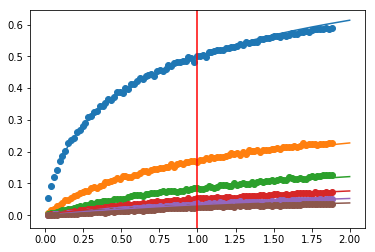

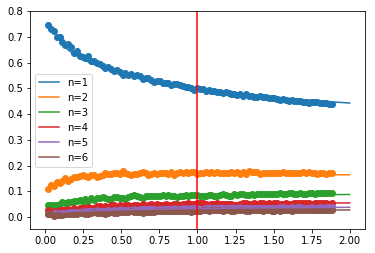

In [24]:
from math import factorial as fact

# integral
def I_n(n:int, x:float):
    
    # validate
    assert isinstance(n, int)
    assert n > 0
    
    # base
    if n == 1:
        answer = x - np.log(x) - 1
        return answer
    
    # else recurse
    answer = n/(n-1) * I_n(n-1, x) + (1-x)/(n-1) * ((x-1)/x)**(n-1)
    return answer

# integrand
def I_np(n:int, x:float):
    return (x-1)**n/x**n

# integrand derivative
def I_npp(n:int, x:float):
    return n*(x-1)**(n-1)/x**(n+1)

# k'_n(x) = k_n(x)/N_z
def k_n(n:int, x:float):
    
    # validate
    assert isinstance(n, int)
    assert n > 0
    
    # calculate answer
    answer = x**n/n * I_n(n, x)/(x-1)**(n+1)
    return answer

# p_n(x) = k_n(x)/E(x)
def p_n(n:int, x:float):
    
    # validate
    assert isinstance(n, int)
    assert n > 0
    
    # calculate answer
    answer = 1/n/x/np.log(x) * (x/(x-1))**n * I_n(n, x)
    return answer

## k'_n(x)
# actual data
ttr = corpus.TTR.copy()
ttr.index = ttr.m_tokens / corpus.M_z
plt.scatter(ttr.index, ttr.lego_1 / corpus.N_z)
plt.scatter(ttr.index, ttr.lego_2 / corpus.N_z)
plt.scatter(ttr.index, ttr.lego_3 / corpus.N_z)
plt.scatter(ttr.index, ttr.lego_4 / corpus.N_z)
plt.scatter(ttr.index, ttr.lego_5 / corpus.N_z)
plt.scatter(ttr.index, ttr.lego_6 / corpus.N_z)

# theory
EPS = 0.1
x = np.append( np.linspace(EPS, 1-EPS, 99), np.linspace(1 + EPS, 2, 99) )
for n in [1, 2, 3, 4, 5, 6]:
    y = k_n(n, x)
    plt.plot(x, y, label = f"n={n}")
plt.axvline(x = 1, color = 'r')
# plt.legend()
plt.show()

## r_n(x)
# actual data
ttr = corpus.TTR.copy()
ttr.index = ttr.m_tokens / corpus.M_z
plt.scatter(ttr.index, ttr.lego_1 / ttr.n_types)
plt.scatter(ttr.index, ttr.lego_2 / ttr.n_types)
plt.scatter(ttr.index, ttr.lego_3 / ttr.n_types)
plt.scatter(ttr.index, ttr.lego_4 / ttr.n_types)
plt.scatter(ttr.index, ttr.lego_5 / ttr.n_types)
plt.scatter(ttr.index, ttr.lego_6 / ttr.n_types)

# theory
EPS = 0.1
x = np.append( np.linspace(EPS, 1-EPS, 99), np.linspace(1 + EPS, 2, 99) )
for n in [1, 2, 3, 4, 5, 6]:
    y = p_n(n, x)
    plt.plot(x, y, label = f"n={n}")
plt.axvline(x = 1, color = 'r')
plt.legend()
plt.show()

In [10]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(x):
    E, k = corpus.log_formula(x)
    k = k / E
    i = np.arange(1, k.shape[1])
    return plt.bar(i, k[0][1:])


interact(f, x = widgets.FloatSlider(min = 0.00, max = 10.00, step = 0.05, value = 1.00));

interactive(children=(FloatSlider(value=1.0, description='x', max=10.0, step=0.05), Output()), _dom_classes=('…

In [72]:
tokens = np.random.choice(corpus.tokens, corpus.M_z)
opticorpus = Corpus(tokens)

def f(x):

    # plot the k-vector
    i = range(1,50)
    plt.bar(i, opticorpus.k[i])
    plt.plot(i, opticorpus.k[1]/np.array(i)**x, color = 'r')
    plt.title("n-Legomena Distribution")
    plt.xlabel("n = word occurences")
    plt.ylabel("words appearing n times")
    plt.show()

interact(f, x = widgets.FloatSlider(min = 1.00, max = 2.00, step = 0.01, value = 1.20));

Number of tokens (<corpus>.M): 113034
Number of types  (<corpus>.N): 10751
Legomena vector  (<corpus>.k): [   0 4233 2207 1142  694  433  343  243  164]
Frequency distribution accessible as <corpus>.fdist


interactive(children=(FloatSlider(value=1.2, description='x', max=2.0, min=1.0, step=0.01), Output()), _dom_cl…

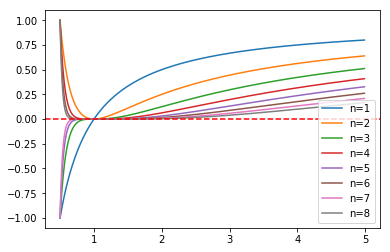

In [88]:

t = np.arange(0.5, 5., 0.01)
for n in range(1, 9):
    plt.plot(t, (t-1)**n/t**n, label = f"n={n}")

plt.axhline(y = 0, color = 'r', linestyle='--')
plt.legend()
plt.show()